/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


  0%|          | 0.00/170M [00:00<?, ?B/s]
  0%|          | 229k/170M [00:00<01:22, 2.07MB/s]
  1%|          | 1.51M/170M [00:00<00:20, 8.05MB/s]
  3%|▎         | 4.59M/170M [00:00<00:09, 18.1MB/s]
  6%|▌         | 10.1M/170M [00:00<00:05, 29.1MB/s]
  8%|▊         | 13.3M/170M [00:00<00:05, 30.1MB/s]
 10%|▉         | 16.3M/170M [00:00<00:07, 21.1MB/s]
 11%|█         | 18.7M/170M [00:00<00:08, 18.3MB/s]
 12%|█▏        | 20.7M/170M [00:01<00:08, 17.6MB/s]
 14%|█▍        | 24.4M/170M [00:01<00:06, 21.6MB/s]
 16%|█▌        | 26.7M/170M [00:01<00:07, 19.7MB/s]
 17%|█▋        | 28.9M/170M [00:01<00:07, 19.6MB/s]
 19%|█▊        | 31.8M/170M [00:01<00:06, 21.4MB/s]
 20%|██        | 34.2M/170M [00:01<00:06, 22.2MB/s]
 22%|██▏       | 37.1M/170M [00:01<00:05, 23.5MB/s]
 23%|██▎       | 39.5M/170M [00:01<00:06, 21.8MB/s]
 25%|██▍       | 41.8M/170M [00:02<00:05, 21.5MB/s]
 26%|██▌       | 44.0M/170M [00:02<00:05, 21.5MB/s]
 27%|██▋       | 46.2M/170M [00:02<00:05, 21.5MB/s]
 28%|██▊       | 48.4

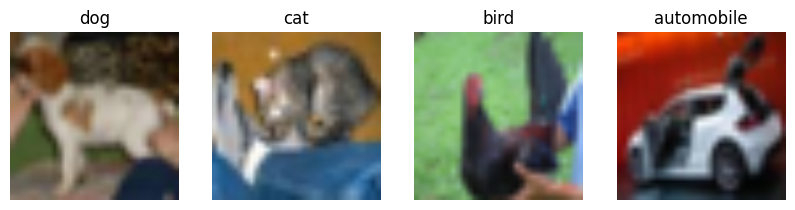

Similitud coseno entre textos (filas) y imágenes (columnas):


,Image: dog,Image: cat,Image: bird,Image: automobile
a photo of a dog,27.33,23.299999,27.219999,22.84
a photo of a cat,23.99,24.129999,24.570000,22.59
a photo of a bird,21.67,22.730000,27.770000,22.66
a photo of a automobile,20.68,21.129999,23.650000,29.33



Predicciones más probables por imagen:
Imagen: dog        -> Texto más cercano: a photo of a dog          (similitud = 27.33)
Imagen: cat        -> Texto más cercano: a photo of a cat          (similitud = 24.13)
Imagen: bird       -> Texto más cercano: a photo of a bird         (similitud = 27.77)
Imagen: automobile -> Texto más cercano: a photo of a automobile   (similitud = 29.33)


In [1]:
!pip install -q torch torchvision transformers pillow matplotlib pandas seaborn

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Cargar modelo CLIP ---
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

# --- Cargar dataset CIFAR-10 ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# --- Clases y textos ---
classes = ["dog", "cat", "bird", "automobile"]
texts = [f"a photo of a {cls}" for cls in classes]

# --- Extraer una imagen por clase ---
images, labels = [], []
for cls in classes:
    idx = dataset.classes.index(cls)
    for img, label in dataset:
        if label == idx:
            images.append(img)
            labels.append(cls)
            break

# --- Mostrar imágenes ---
plt.figure(figsize=(10, 3))
for i, (img, lbl) in enumerate(zip(images, labels)):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(lbl)
    plt.axis("off")
plt.show()

# --- Procesar imágenes y texto ---
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to(device)

# --- Obtener embeddings ---
with torch.no_grad():
    outputs = model(**inputs)
    image_embeds = outputs.image_embeds
    text_embeds = outputs.text_embeds
    # Normalizar
    image_embeds /= image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds /= text_embeds.norm(p=2, dim=-1, keepdim=True)

# --- Calcular similitud coseno ---
similarity = (image_embeds @ text_embeds.T) * 100

# --- DataFrame transpuesto (textos en filas, imágenes en columnas) ---
df = pd.DataFrame(similarity.cpu().numpy().T, index=texts, columns=[f"Image: {c}" for c in labels])
print("Similitud coseno entre textos (filas) y imágenes (columnas):")
display(df.round(2))

# --- Predicción más probable por imagen ---
pred_indices = similarity.argmax(dim=1)
pred_labels = [texts[i] for i in pred_indices]

print("\nPredicciones más probables por imagen:")
for true, pred, sim in zip(labels, pred_labels, similarity.max(dim=1).values):
    print(f"Imagen: {true:<10} -> Texto más cercano: {pred:<25} (similitud = {sim.item():.2f})")
